# Generate stock dataset

In [0]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

In [0]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [0]:
import numpy as np
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

Saving figure stock_plot


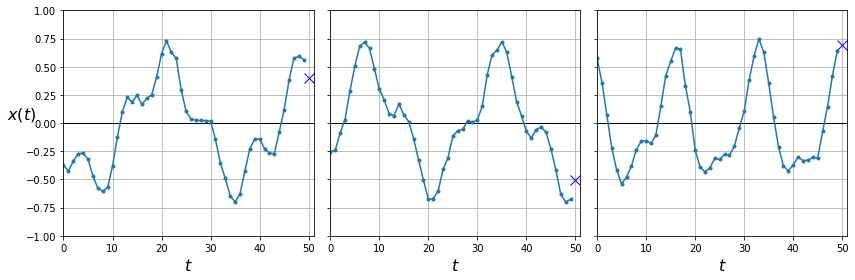

In [9]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join('/content', fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("stock_plot")
plt.show()

# LSTM

In [25]:

np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
np.random.seed(42)
tf.random.set_random_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0792 - last_time_step_mse: 0.0650 - val_loss: 0.0561 - val_last_time_step_mse: 0.0367
Epoch 2/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0482 - last_time_step_mse: 0.0273 - val_loss: 0.0425 - val_last_time_step_mse: 0.0217
Epoch 3/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0391 - last_time_step_mse: 0.0182 - val_loss: 0.0369 - val_last_time_step_mse: 0.0167
Epoch 4/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0351 - last_time_step_mse: 0.0151 - val_loss: 0.0337 - val_last_time_step_mse: 0.0142
Epoch 5/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0329 - last_time_step_mse: 0.0138 - val_loss: 0.0318 - val_last_time_step_mse: 0.0128
Epoch 6/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0314 - last_time_step_mse: 0.0131 - 

In [18]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 1s 325us/sample - loss: 0.0240 - last_time_step_mse: 0.0086


[0.02397196401655674, 0.008587645]

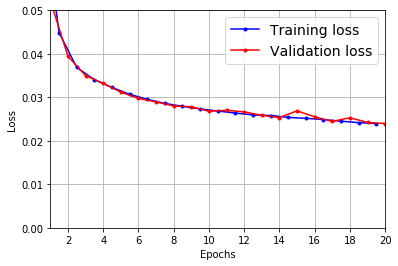

In [20]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

# CONV1D

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import keras
from keras import backend as K
import datetime as dt
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
import os

RAND_SEED = 1
np.random.seed(RAND_SEED)

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
def generate_stock_list(path, max_symbols):
    all_stocks = np.array([f.split(".")[0] for f in os.listdir(path)])
    return all_stocks[np.random.choice(len(all_stocks), max_symbols)]

# Stocks and ETFs we'll be using
BASE_PATH = "/content/drive/My Drive/stock-prediction/"
#STOCKS = ["tsla", "amzn", "fb", "aapl", "nvda", "goog", "nflx", "baba", "amd", "wmt", "bidu", "snap", "ibm", "f", "gm", "fcau", "twtr", "pzza"]
STOCKS = generate_stock_list(BASE_PATH + "Stocks/", 500) #Increase this number to have more samples
ETFS = ["spy", "qqq", "eem", "xlf", "gdx", "vxx", "ewz", "uso", "xlk", "hyg", "iyr", "tlt", "lqd", "agg", "ief", "veu", "fxi"]

def load_symbol_df(dir_path, file_name, out_array):
    full_path = dir_path + file_name
    if os.stat(full_path).st_size > 0: 
        df = pd.read_csv(full_path)
        columns = list(df.columns.values)
        symbol = file_name.split(".")[0]
        df["Symbol"] = symbol
        columns.insert(0, "Symbol")
        out_array.append(df[columns])
        
def load_data():
    print("Loading {} symbols".format(len(STOCKS) + len(ETFS)))
    all_files_df = []
    [load_symbol_df(BASE_PATH + "Stocks/", name + ".us.txt", all_files_df) for name in STOCKS]
    [load_symbol_df(BASE_PATH + "ETFs/", name + ".us.txt", all_files_df) for name in ETFS]
    merged_df = pd.concat(all_files_df)
    all_dates = merged_df["Date"].unique()
    print("Total symbols loaded: ", len(merged_df["Symbol"].unique()))
    print("Dates from: {}, to: {}, total: {}".format(all_dates.min(), all_dates.max(), len(all_dates)))
    print("DataFrame size: ", len(merged_df))
    return merged_df
    
df = load_data()

Loading 517 symbols
Total symbols loaded:  477
Dates from: 1970-01-02, to: 2017-11-10, total: 12076
DataFrame size:  1095100


In [0]:
FEATURE_VEC = ["Open", "Close", "High", "Low", "Volume"]

# Create samples of a given size and with the given labels
def create_samples(df, windowLength, predDaysForward, labels, skipDays):
    X = []
    Y = []
    symbols = df["Symbol"].unique()
    totalSamples = 0
    for symbol in symbols:
        symbol_df = df[df["Symbol"] == symbol]
        avail_days = len(symbol_df) - windowLength + 1 - predDaysForward
        startIdx = 0
        while startIdx < avail_days:
            X.append(to_X(symbol_df, startIdx, windowLength))
            Y.append(to_Y(symbol_df, startIdx, windowLength, predDaysForward, labels))
            startIdx += skipDays
            totalSamples += 1
    return (np.array(X).reshape((totalSamples, windowLength, len(FEATURE_VEC))), 
            np.array(Y).reshape((totalSamples, len(labels))))
 
# Create feture vec
def to_X(df, startIdx, windowLength):
    X = []
    winEndIdx = startIdx + windowLength
    for item in FEATURE_VEC:
        values = df[item].values
        X.append(to_percentage(values[startIdx:winEndIdx], values[winEndIdx-1]))
    return X

# Create label vec
def to_Y(df, startIdx, windowLength, predDaysForward, labels):
    prices = df["Close"].values
    ret = to_percentage(prices[startIdx + windowLength -1], prices[startIdx + windowLength -1 + predDaysForward]) * 100.0
    label_vec = np.zeros(len(labels), dtype="float32")
    for label in labels:
        if ret >= label["from"] and ret < label["to"]:
            label_vec[label["label"]] = 1.0
            break
    return label_vec
    
# Make values relative to a reference value
def to_percentage(values, base_value):
    base_value = max(base_value, 0.001)
    return ((values - base_value) / base_value).astype("float32")

def shuffle_XY(X, Y):
    shuffleIndexes = np.arange(Y.shape[0])
    np.random.shuffle(shuffleIndexes)
    return (X[shuffleIndexes], Y[shuffleIndexes])

# Split into train and test set with a balanced number of samples for each class
def balance_samples(X, Y, labels, trainSetProportion):
    # Find class with minimum number of samples
    print("X shape: {}, Y shape: {}".format(X.shape, Y.shape))
    Y_num = np.argmax(Y, axis=1)
    indices_per_label = [np.nonzero(Y_num == label)[0] for label in labels]
    tot_per_label = np.array([len(indices) for indices in indices_per_label])
    min_class = tot_per_label.min()
    print("Total samples: {}, Min samples per class: {}. Count per class: {}".format(len(Y), min_class, tot_per_label))
    indices_per_label = [indices[np.random.choice(len(indices), min_class)] for indices in indices_per_label]
    
    # Split all samples per class by train/test
    samples_per_label_split = []
    tot_train_samples = 0
    tot_test_samples = 0
    for label in labels:
        X_label = X[indices_per_label[label]]
        Y_label = Y[indices_per_label[label]]
        X_train, X_test, Y_train, Y_test = train_test_split(X_label, Y_label, test_size=1-trainSetProportion, random_state=RAND_SEED)
        tot_train_samples += len(Y_train)
        tot_test_samples += len(Y_test)
        samples_per_label_split.append((X_train, X_test, Y_train, Y_test))
    
    # Append all
    X_train = np.concatenate([s[0] for s in samples_per_label_split])
    X_test = np.concatenate([s[1] for s in samples_per_label_split])
    Y_train = np.concatenate([s[2] for s in samples_per_label_split])
    Y_test = np.concatenate([s[3] for s in samples_per_label_split])
    
    # Reshuffle
    X_train, Y_train = shuffle_XY(X_train, Y_train)
    X_test, Y_test = shuffle_XY(X_test, Y_test)
    
    print("Train samples: {}, Test samples: {}".format(len(Y_train), len(Y_test)))
    return (X_train, X_test, Y_train, Y_test)
    
def create_and_balance_samples(df, windowLength, predDaysForward, labels, trainSetProportion, skipDays):
    X, Y = create_samples(df, windowLength, predDaysForward, labels, skipDays)
    labels_num = [label["label"] for label in labels]
    return balance_samples(X, Y, labels_num, trainSetProportion)

def plot_training_progress(progress):
    # Get data
    y_loss = [i["loss"] for i in progress]
    y_val_loss = [i["val_loss"] for i in progress]
    y_acc = [i["categorical_accuracy"] for i in progress]
    y_val_acc = [i["val_categorical_accuracy"] for i in progress]
    x = np.arange(len(y_loss))
    
    #Plot loss
    fig, ax = plt.subplots(1,1, figsize=(20,8))
    plt.scatter(x, y_loss, c="red", label="Train loss")
    plt.plot(x, y_loss, color="red")
    plt.scatter(x, y_val_loss, c="blue", label="Val loss")
    plt.plot(x, y_val_loss, color="blue")
    plt.title("Loss progress", fontsize=16)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend()
    plt.show()
    
    #Plot accuracy
    fig, ax = plt.subplots(1,1, figsize=(20,8))
    plt.scatter(x, y_acc, c="red", label="Train accuracy")
    plt.plot(x, y_acc, color="red")
    plt.scatter(x, y_val_acc, c="blue", label="Val accuracy")
    plt.plot(x, y_val_acc, color="blue")
    plt.title("Accuracy progress", fontsize=16)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend()
    plt.show()

In [0]:
def create_conv1D_model(windowLength, predDaysForward, labels):
    model = keras.models.Sequential([
        keras.layers.Conv1D(32, 3, activation='relu', input_shape=(windowLength, len(FEATURE_VEC))),
        keras.layers.Conv1D(32, 3, activation='relu'),
        keras.layers.MaxPooling1D(3),
        keras.layers.Conv1D(64, 3, activation='relu'),
        keras.layers.Conv1D(64, 3, activation='relu'),
        keras.layers.MaxPooling1D(3),
        keras.layers.Conv1D(128, 3, activation='relu'),
        keras.layers.Conv1D(128, 3, activation='relu'),
        keras.layers.Conv1D(128, 3, activation='relu'),
        keras.layers.MaxPooling1D(3),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(len(labels), activation="softmax")
    ])
    return ("Conv1D", model)
        
# MLP model
def create_simple_dense_model(windowLength, predDaysForward, labels):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(windowLength, len(FEATURE_VEC))),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(len(labels), activation="softmax")
    ])
    return ("SimpleDense", model)

# LSTM model
def create_LSTM_model(windowLength, predDaysForward, labels):
    model = keras.models.Sequential([
        keras.layers.LSTM(32, input_shape=(windowLength, len(FEATURE_VEC))),
        keras.layers.Dense(len(labels), activation="softmax")
    ])
    return ("LSTM", model)
    
# Conv1D + LSTM model
def create_conv1D_LSTM_model(windowLength, predDaysForward, labels):
    model = keras.models.Sequential([
        keras.layers.Conv1D(32, 5, activation='relu', input_shape=(windowLength, len(FEATURE_VEC))),
        keras.layers.Conv1D(32, 5, activation='relu'),
        keras.layers.MaxPooling1D(5),
        keras.layers.Conv1D(64, 5, activation='relu'),
        keras.layers.Conv1D(64, 5, activation='relu'),
        keras.layers.MaxPooling1D(5),
        keras.layers.LSTM(32, return_sequences=True, recurrent_dropout=0.5),
        keras.layers.LSTM(32, recurrent_dropout=0.5),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(len(labels), activation="softmax")
    ])
    return ("Conv1D-LSTM", model)
    
# Create model
def train_and_eval_model(X_train, X_test, Y_train, Y_test, windowLength, predDaysForward, labels, createModelFunc, 
                         epoch_rounds, log_steps, load_weights=False):
    # Create Keras model
    model_name, model = createModelFunc(windowLength, predDaysForward, labels)
    print("Model: ", model_name)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[keras.metrics.categorical_accuracy])
    model.summary()
    
    # Callbacks to print status
    progress = []
    def print_progress(epoch, logs):
        progress.append(logs)
        if epoch % log_steps == 0:
            print("\tEpoch {}, Loss Train-Val: {} - {}, Accuracy Train-Val: {} - {}".format(
                epoch, round(logs["loss"],6), round(logs["val_loss"],6), round(logs["loss"],6),
                round(logs["categorical_accuracy"],6), round(logs["val_categorical_accuracy"],6)
            ))
        
    model_base_path = "models/"
    if not os.path.exists(model_base_path):
        os.makedirs(model_base_path)
    model_path = model_base_path + "stocksClassifMultiFeature_{}_history{}_forward{}".format(model_name, windowLength, predDaysForward)
    fit_callbacks = [
        keras.callbacks.ModelCheckpoint(model_path, monitor="loss", save_weights_only=True),
        keras.callbacks.LambdaCallback(on_epoch_end = lambda epoch, logs: print_progress(epoch, logs))
    ]
    
    # Load existing weights
    if load_weights:
        print("Loading pre-trained weights from: ", model_path)
        model.load_weights(model_path)
    
    # Train model, plot status after each round
    BATCH_SIZE = 64
    for r, epochs in enumerate(epoch_rounds):
        print("Training round: {} with {} epochs".format(r, epochs))
        model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=epochs, verbose=0, callbacks=fit_callbacks, validation_data=(X_test, Y_test))
        plot_training_progress(progress)
    model.save_weights(model_path)
    print("Training done")
    
    # Get predictions
    print("Predicting...")
    score_train = model.evaluate(X_train, Y_train, verbose=0)
    score_test = model.evaluate(X_test, Y_test, verbose=0)
    print("Train set - Loss: {}, Accuracy: {}%".format(round(score_train[0],4), round(score_train[1]*100.0,4)))
    print("Test set - Loss: {}, Accuracy: {}%".format(round(score_test[0],4), round(score_test[1]*100.0,4)))
    
    return model

In [6]:
# Create samples
WINDOW_SIZE = 260 # 1 year of historical data (change this to increase/decrease window)
FORWARD_DAYS = 60 # predict 3 months in the future
SKIP_DAYS = 5 # when creating samples how many days we skip from window to window
TRAIN_TEST_SPLIT = 0.8 # 80% samples for train, 20% for test
LABELS = [ # Multi-label problem
    {"label": 0, "name": "10% loss", "from": -99999999.0, "to": -10.0, "return": -0.1},
    {"label": 1, "name": "Flat", "from": -10, "to": 10, "return": 0},
    {"label": 2, "name": "10% return", "from": 10, "to": 99999999.0, "return": 0.1}
]

X_train, X_test, Y_train, Y_test = create_and_balance_samples(df, WINDOW_SIZE, FORWARD_DAYS, LABELS, TRAIN_TEST_SPLIT, SKIP_DAYS)

X shape: (191957, 260, 5), Y shape: (191957, 3)
Total samples: 191957, Min samples per class: 42393. Count per class: [ 46246 103318  42393]
Train samples: 101742, Test samples: 25437







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model:  Conv1D


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 258, 32)           512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 256, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 85, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 83, 64)            6208      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 81, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 64)      

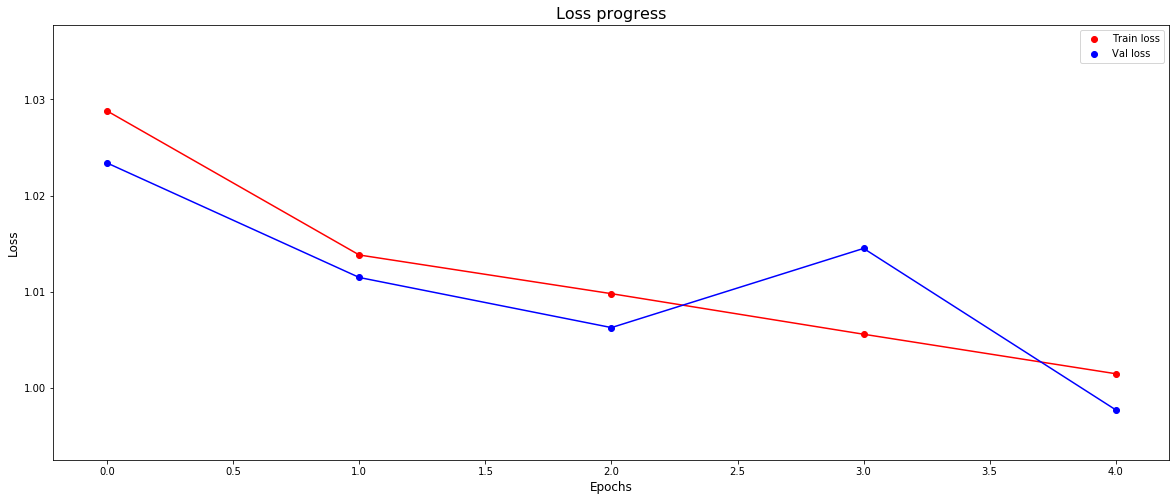

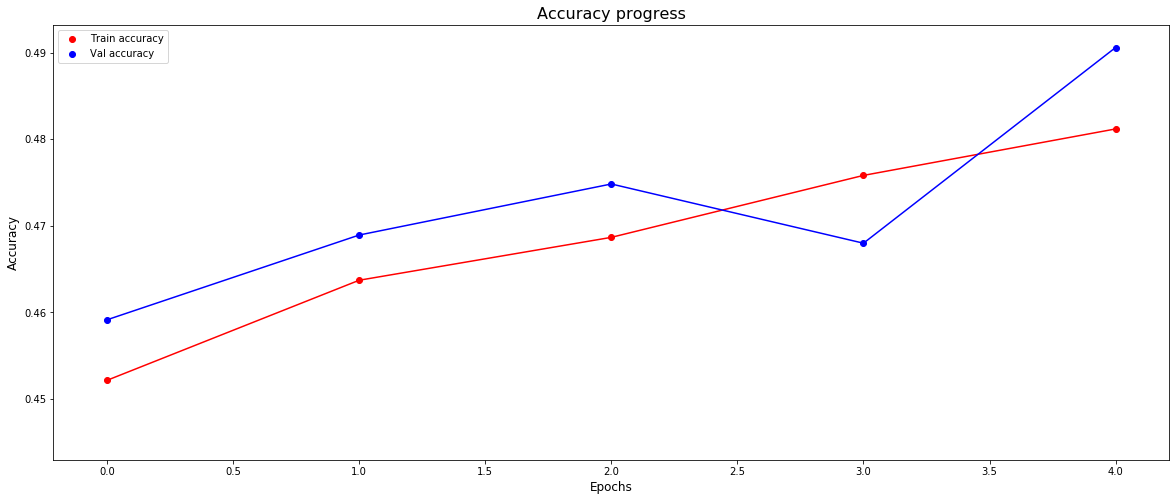

Training done
Predicting...
Train set - Loss: 0.991, Accuracy: 49.2412%
Test set - Loss: 0.9977, Accuracy: 49.0585%


In [7]:
# Train model
EPOCH_ROUNDS = [5] # Rounds of epochs to be used, change to something like this [10, 10, 5, 5] for better training
model = train_and_eval_model(X_train, X_test, Y_train, Y_test, WINDOW_SIZE, FORWARD_DAYS, LABELS, create_conv1D_model,
                             EPOCH_ROUNDS, log_steps=1, load_weights=False)